# Analyse exploratoire du churn bancaire (BankChurners)

Ce projet propose une analyse exploratoire complète des données clients d’une institution bancaire afin d’identifier les facteurs associés à l’attrition (résiliation).  
L’approche combine hygiène de données, visualisations claires et modélisation explicable, avec un objectif de rigueur analytique et de reproductibilité.

**Contenus principaux :**
- Exploration univariée, bivariée et multivariée
- Nettoyage des données et documentation des variables
- Détection et traitement des valeurs manquantes
- Tests statistiques (Mann–Whitney, Chi²) pour valider les différences significatives
- Détection d’anomalies (IQR)
- Création de variables dérivées (*feature engineering*)
- Réduction de dimensionnalité (PCA, t-SNE) et segmentation (KMeans)
- Mini-modèle explicable (régression logistique) avec métriques et visualisations associées

**Objectif :** fournir une analyse claire, documentée et interprétable qui facilite la compréhension des leviers du churn et alimente la prise de décision stratégique.


## Résumé exécutif

L’étude porte sur les données clients de l’ensemble *BankChurners*, avec pour objectif d’identifier les facteurs majeurs influençant la résiliation des comptes.  
Elle combine analyse exploratoire approfondie, méthodes statistiques et modélisation interprétable pour fournir une vision claire des leviers du churn.

**Constats principaux :**
- Taux d’attrition global observé : `X %` (calculé lors de l’exécution).
- Variables les plus discriminantes : activité transactionnelle (`Total_Trans_Ct`, `Total_Trans_Amt`), variations trimestrielles (`Total_Ct_Chng_Q4_Q1`, `Total_Amt_Chng_Q4_Q1`), inactivité récente (`Months_Inactive_12_mon`).
- Influence notable de certaines tranches de revenus, catégories de carte et profils démographiques.

**Approche méthodologique :**
- Nettoyage et normalisation des données, traitement des valeurs manquantes et des codes “Unknown”.
- Analyses univariées, bivariées et multivariées avec visualisations claires.
- Tests statistiques (Mann–Whitney, Chi²) pour valider les écarts significatifs.
- Modélisation via régression logistique avec métriques (ROC-AUC, matrice de confusion) et interprétation des coefficients.

**Objectif final :** fournir aux équipes métiers et marketing une base factuelle pour anticiper et réduire le churn, en identifiant les segments à risque et en orientant les actions de rétention.


In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from scipy.stats import chi2_contingency, mannwhitneyu

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
)

%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="Set2")

DATA_PATH = "data/BankChurners.csv"
FIG_DIR = "figuresAnalyse"
os.makedirs(FIG_DIR, exist_ok=True)

def save_fig(fname, dpi=300):
    path = os.path.join(FIG_DIR, fname)
    plt.savefig(path, dpi=dpi, bbox_inches='tight')
    print(f"Saved: {path}")

def wrap_text(s, width=40):
    s = "" if s is None else str(s)
    return "\n".join(textwrap.wrap(s, width=width)) if len(s) > 0 else s

def set_wrapped_title(ax, title, width=60):
    if title:
        ax.set_title(wrap_text(title, width=width))

def wrap_tick_labels(ax, axis='x', width=12):
    if axis == 'x':
        labels = [wrap_text(lbl.get_text(), width) for lbl in ax.get_xticklabels()]
        ax.set_xticklabels(labels)
    else:
        labels = [wrap_text(lbl.get_text(), width) for lbl in ax.get_yticklabels()]
        ax.set_yticklabels(labels)

np.random.seed(42)


## Chargement des données et aperçu

In [2]:
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Données chargées: {df.shape[0]} lignes x {df.shape[1]} colonnes")
except FileNotFoundError:
    raise FileNotFoundError(f"Fichier non trouvé. Vérifie DATA_PATH: {DATA_PATH}")

display(df.head())
print("\nTypes et informations générales:")
df.info()
print("\nStatistiques descriptives (numériques):")
display(df.describe().T)


Données chargées: 10127 lignes x 23 colonnes


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998



Types et informations générales:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                         

,count,mean,std,min,25%,50%,75%,max
CLIENTNUM,10127.0,7.391776e+08,3.690378e+07,7.080821e+08,7.130368e+08,7.179264e+08,7.731435e+08,8.283431e+08
Customer_Age,10127.0,4.632596e+01,8.016814e+00,2.600000e+01,4.100000e+01,4.600000e+01,5.200000e+01,7.300000e+01
Dependent_count,10127.0,2.346203e+00,1.298908e+00,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00
Months_on_book,10127.0,3.592841e+01,7.986416e+00,1.300000e+01,3.100000e+01,3.600000e+01,4.000000e+01,5.600000e+01
Total_Relationship_Count,10127.0,3.812580e+00,1.554408e+00,1.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00
Months_Inactive_12_mon,10127.0,2.341167e+00,1.010622e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Contacts_Count_12_mon,10127.0,2.455317e+00,1.106225e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Credit_Limit,10127.0,8.631954e+03,9.088777e+03,1.438300e+03,2.555000e+03,4.549000e+03,1.106750e+04,3.451600e+04
Total_Revolving_Bal,10127.0,1.162814e+03,8.149873e+02,0.000000e+00,3.590000e+02,1.276000e+03,1.784000e+03,2.517000e+03
Avg_Open_To_Buy,10127.0,7.469140e+03,9.090685e+03,3.000000e+00,1.324500e+03,3.474000e+03,9.859000e+03,3.451600e+04


## Data dictionary (résumé)

| Colonne | Type attendu | Description |
|---|---|---|
| CLIENTNUM | ID | Identifiant client (à exclure des modèles) |
| Attrition_Flag | Catégorie | Statut: Existing Customer / Attrited Customer |
| Customer_Age | Numérique | Âge du client |
| Gender | Catégorie | Genre |
| Dependent_count | Numérique | Nb. de personnes à charge |
| Education_Level | Catégorie | Niveau d’études |
| Marital_Status | Catégorie | Statut marital |
| Income_Category | Catégorie | Catégorie de revenu |
| Card_Category | Catégorie | Type de carte |
| Months_on_book | Numérique | Ancienneté (mois) |
| Total_Relationship_Count | Numérique | Nb. de produits détenus |
| Months_Inactive_12_mon | Numérique | Mois d’inactivité (12 derniers mois) |
| Contacts_Count_12_mon | Numérique | Contacts (12 derniers mois) |
| Credit_Limit | Numérique | Plafond de crédit |
| Total_Revolving_Bal | Numérique | Solde revolving |
| Avg_Open_To_Buy | Numérique | Crédit disponible moyen |
| Total_Amt_Chng_Q4_Q1 | Numérique | Variation des montants (Q4 vs Q1) |
| Total_Trans_Amt | Numérique | Montant total des transactions |
| Total_Trans_Ct | Numérique | Nombre total de transactions |
| Total_Ct_Chng_Q4_Q1 | Numérique | Variation du nb de transactions (Q4 vs Q1) |
| Avg_Utilization_Ratio | Numérique | Ratio d’utilisation moyen |
| Naive_Bayes_Classifier_..._1/2 | Numérique | Sorties d’un modèle NB (fuite potentielle) |


## Nettoyage et préparation

In [3]:
df_clean = df.copy()

# Retirer colonnes à fuite (leakage)
leak_cols = [c for c in df_clean.columns if c.startswith("Naive_Bayes_Classifier_")]
if leak_cols:
    print("Colonnes retirées (fuite potentielle):", leak_cols)
    df_clean.drop(columns=leak_cols, inplace=True)

# Nettoyer catégories: trim + Unknown -> NaN
cat_cols = df_clean.select_dtypes(include=['object','category']).columns.tolist()
for c in cat_cols:
    df_clean[c] = df_clean[c].astype(str).str.strip()
    df_clean[c] = df_clean[c].replace({"Unknown": np.nan, "unknown": np.nan})

# Convertir objets numériques si possible (sauf ID)
for c in df_clean.columns:
    if df_clean[c].dtype == 'object' and c != 'CLIENTNUM':
        converted = pd.to_numeric(df_clean[c], errors='coerce')
        if converted.notna().mean() > 0.9:
            df_clean[c] = converted

# Mapping cible binaire
if 'Attrition_Flag' in df_clean.columns:
    df_clean['Attrition_Flag'] = df_clean['Attrition_Flag'].map({
        'Existing Customer': 0,
        'Attrited Customer': 1
    }).astype('Int64')
    print("Mapping Attrition_Flag: Existing→0, Attrited→1")

id_cols = [c for c in ['CLIENTNUM'] if c in df_clean.columns]

display(df_clean.head())


Colonnes retirées (fuite potentielle): ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
Mapping Attrition_Flag: Existing→0, Attrited→1


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,0,40,F,4,High School,NaN,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Valeurs manquantes

,missing,missing_pct
Education_Level,1519,15.0
Income_Category,1112,11.0
Marital_Status,749,7.4


Saved: figuresAnalyse\01_missing_heatmap.png


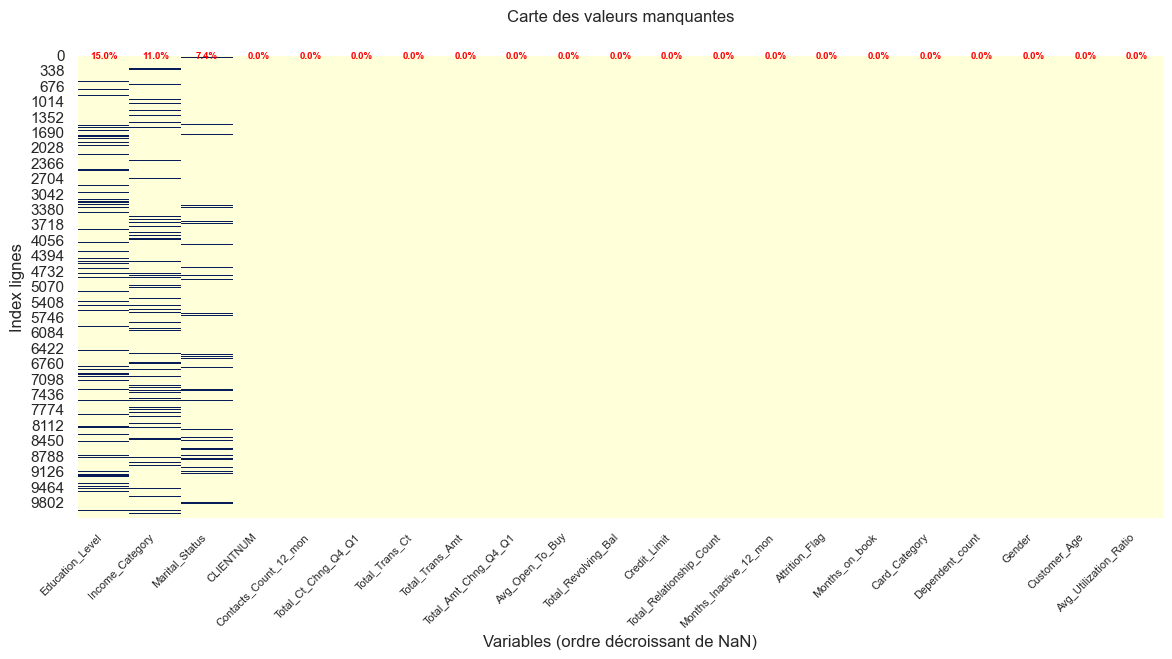

Saved: figuresAnalyse\01b_missing_barplot.png


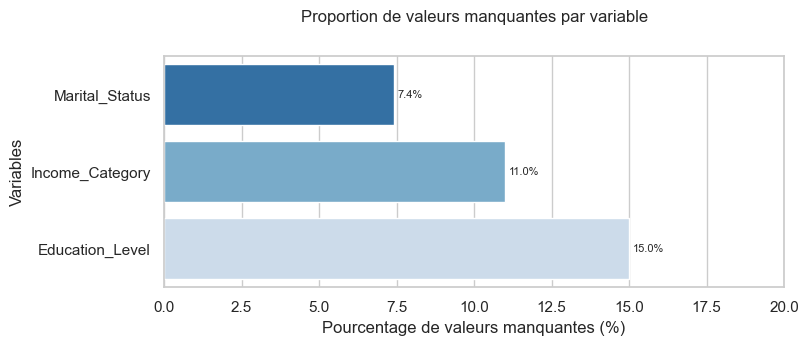

In [12]:

# Calcul des valeurs manquantes et pourcentages
missing = df_clean.isna().sum()
missing_pct = (missing / len(df_clean) * 100).round(1)
df_missing = pd.DataFrame({
    "missing": missing,
    "missing_pct": missing_pct
}).sort_values("missing_pct", ascending=False)

display(df_missing[df_missing["missing"] > 0])

# HEATMAP triée par % de NaN
na_order = df_missing.index.tolist()

plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    df_clean[na_order].isna(),
    cbar=False,
    cmap="YlGnBu"
)

# Rotation des labels + ajout % au-dessus
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
for idx, col in enumerate(na_order):
    pct = missing_pct[col]
    ax.text(
        idx + 0.5, -2, f"{pct:.1f}%",
        ha='center', va='center',
        fontsize=7, color='red', fontweight='bold'
    )

ax.set_title("Carte des valeurs manquantes", pad=25)  # pad = espace avec la figure
ax.set_xlabel("Variables (ordre décroissant de NaN)")
ax.set_ylabel("Index lignes")

save_fig("01_missing_heatmap.png")
plt.show()

# BARPLOT horizontal des % de NaN
missing_pct_plot = missing_pct[missing_pct > 0].sort_values(ascending=True)

plt.figure(figsize=(8, max(3, 0.35 * len(missing_pct_plot))))
ax = sns.barplot(
    x=missing_pct_plot.values,
    y=[wrap_text(c, 20) for c in missing_pct_plot.index],
    palette="Blues_r"
)

ax.set_xlabel("Pourcentage de valeurs manquantes (%)")
ax.set_ylabel("Variables")
ax.set_xlim(0, max(missing_pct_plot.values) + 5)
set_wrapped_title(ax, "Proportion de valeurs manquantes par variable")
ax.set_title(ax.get_title(), pad=25)

# Annotation de chaque barre
for p, val in zip(ax.patches, missing_pct_plot.values):
    ax.annotate(
        f"{val:.1f}%",
        (p.get_width(), p.get_y() + p.get_height()/2),
        ha='left', va='center',
        xytext=(3, 0),
        textcoords='offset points',
        fontsize=8
    )

save_fig("01b_missing_barplot.png")
plt.show()


## Analyse univariée

Colonnes numériques (extrait): ['Attrition_Flag', 'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy']
Saved: figuresAnalyse\02_hist_Attrition_Flag.png


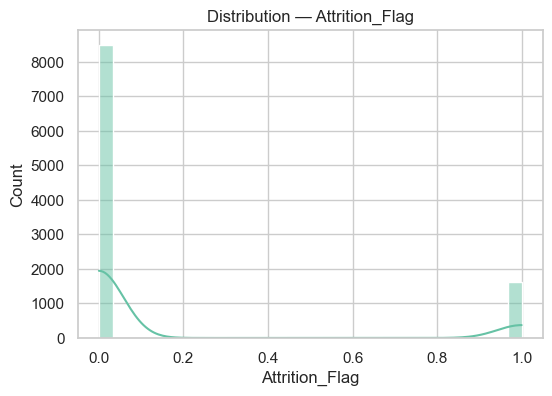

Saved: figuresAnalyse\02_box_Attrition_Flag.png


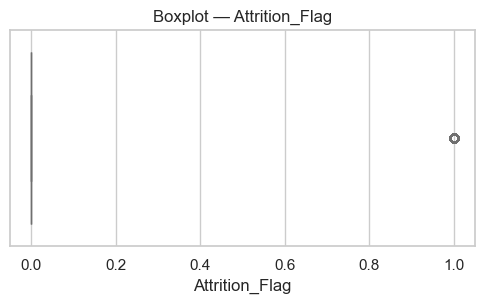

Saved: figuresAnalyse\02_hist_Customer_Age.png


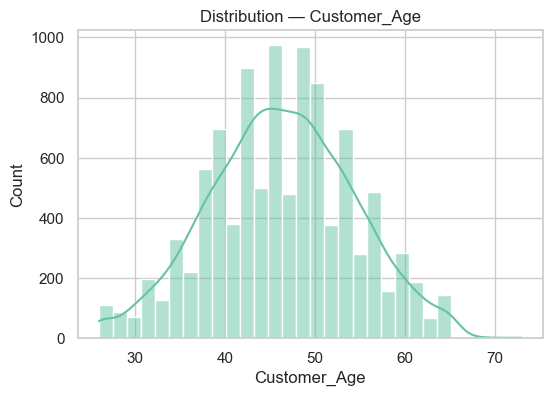

Saved: figuresAnalyse\02_box_Customer_Age.png


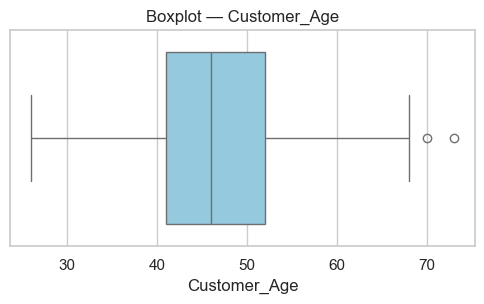

Saved: figuresAnalyse\02_hist_Dependent_count.png


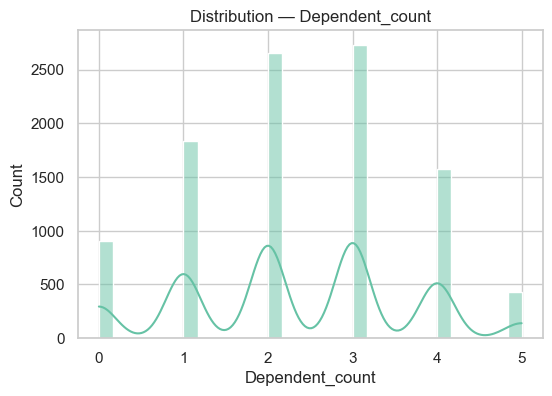

Saved: figuresAnalyse\02_box_Dependent_count.png


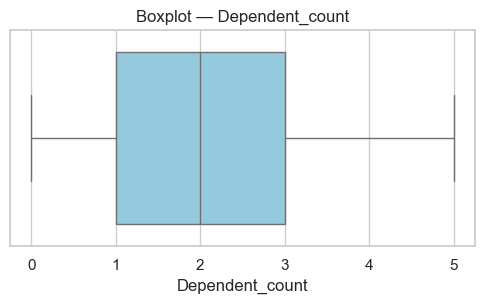

Saved: figuresAnalyse\02_hist_Months_on_book.png


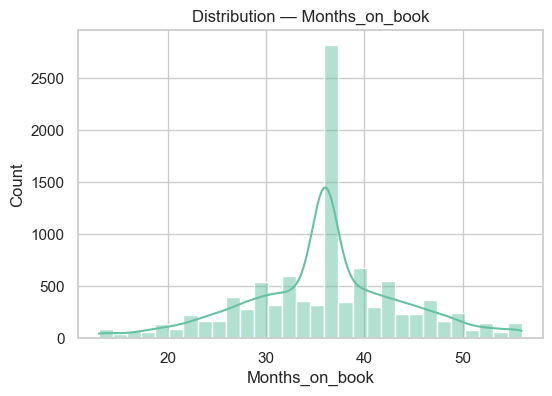

Saved: figuresAnalyse\02_box_Months_on_book.png


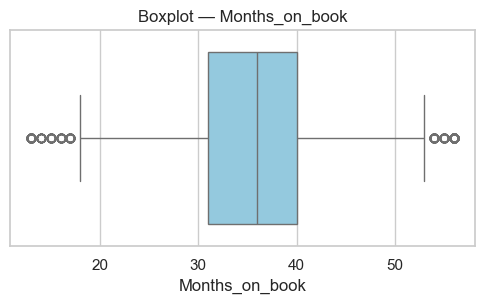

Saved: figuresAnalyse\02_hist_Total_Relationship_Count.png


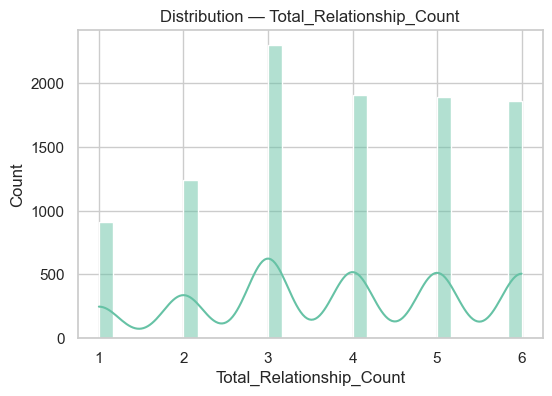

Saved: figuresAnalyse\02_box_Total_Relationship_Count.png


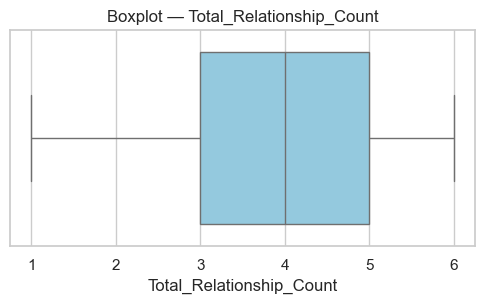

Saved: figuresAnalyse\02_hist_Months_Inactive_12_mon.png


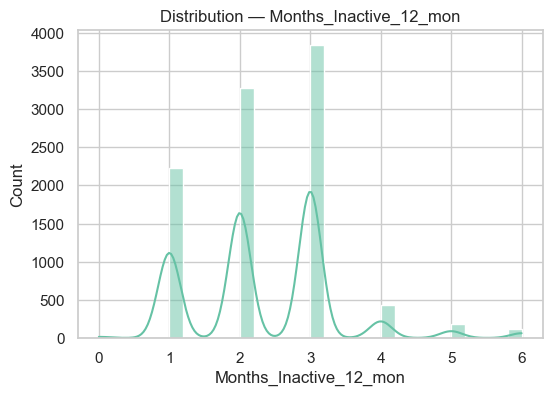

Saved: figuresAnalyse\02_box_Months_Inactive_12_mon.png


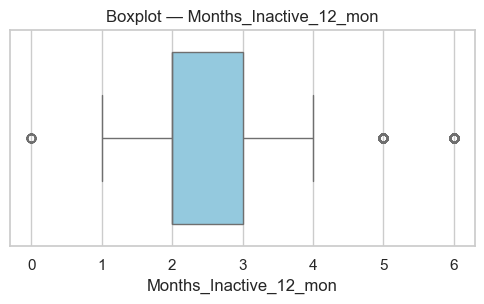

Saved: figuresAnalyse\02_hist_Contacts_Count_12_mon.png


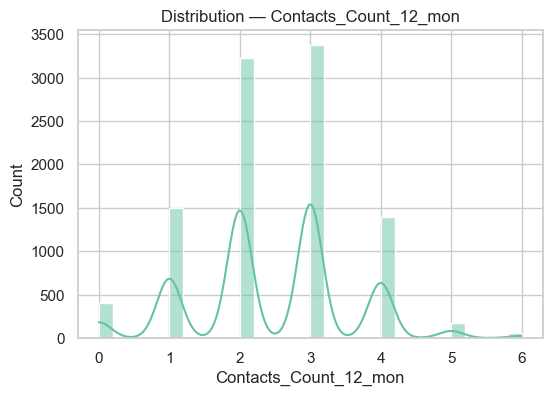

Saved: figuresAnalyse\02_box_Contacts_Count_12_mon.png


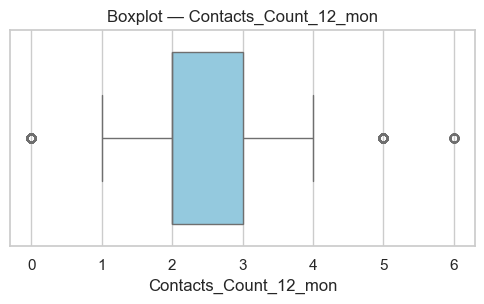

Saved: figuresAnalyse\02_hist_Credit_Limit.png


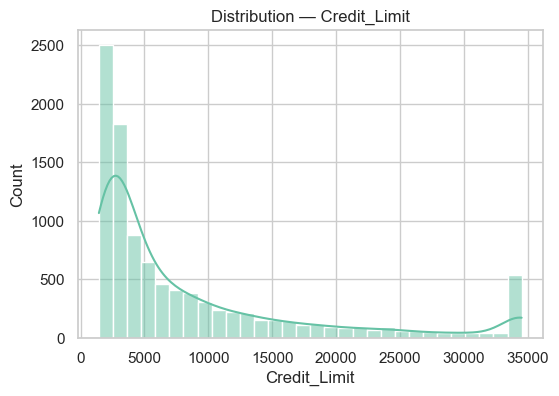

Saved: figuresAnalyse\02_box_Credit_Limit.png


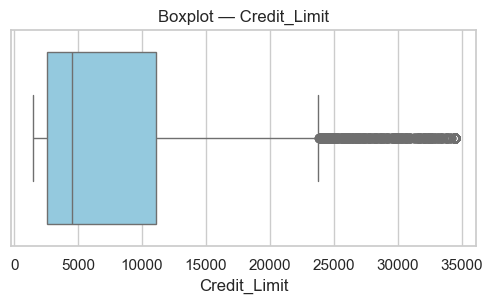

Saved: figuresAnalyse\02_hist_Total_Revolving_Bal.png


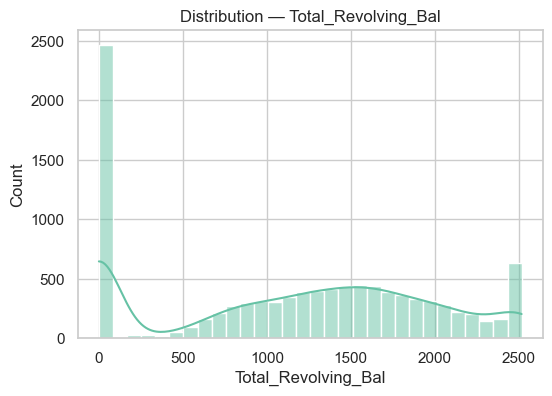

Saved: figuresAnalyse\02_box_Total_Revolving_Bal.png


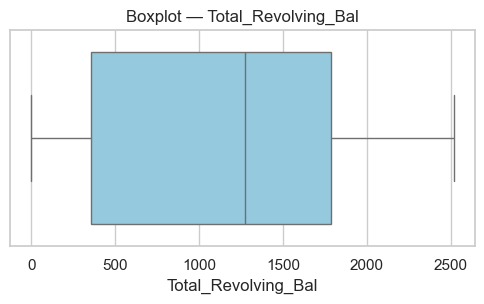

Saved: figuresAnalyse\02_hist_Avg_Open_To_Buy.png


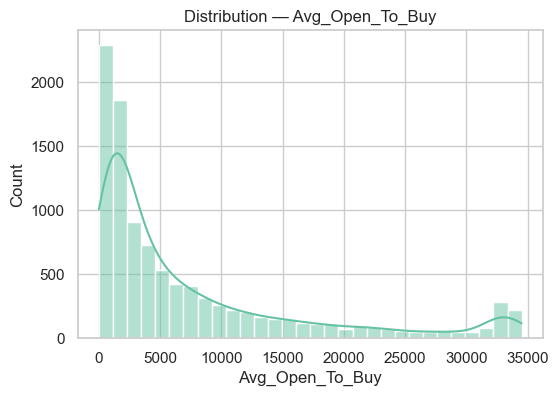

Saved: figuresAnalyse\02_box_Avg_Open_To_Buy.png


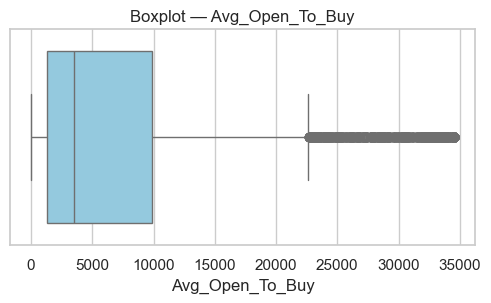

Saved: figuresAnalyse\02_hist_Total_Amt_Chng_Q4_Q1.png


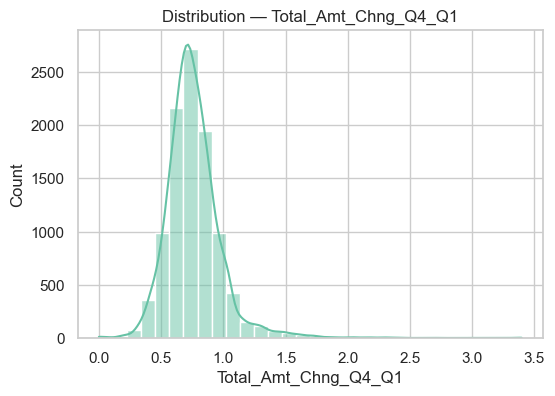

Saved: figuresAnalyse\02_box_Total_Amt_Chng_Q4_Q1.png


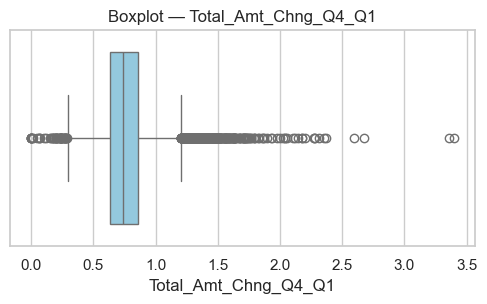

Saved: figuresAnalyse\02_hist_Total_Trans_Amt.png


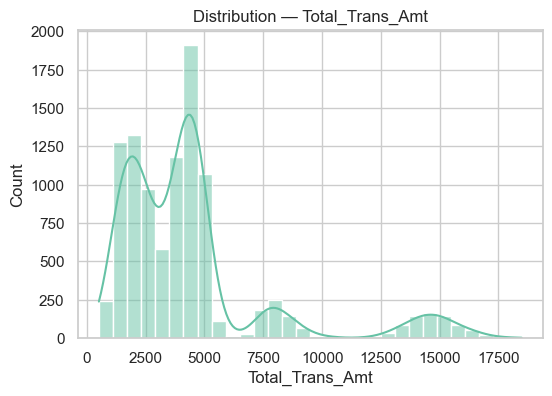

Saved: figuresAnalyse\02_box_Total_Trans_Amt.png


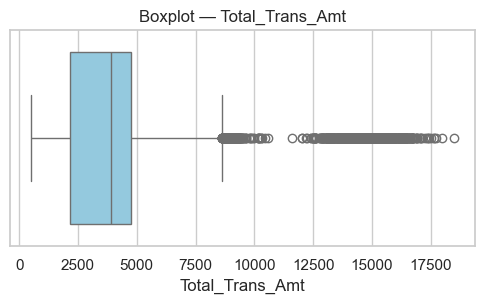

Saved: figuresAnalyse\02_hist_Total_Trans_Ct.png


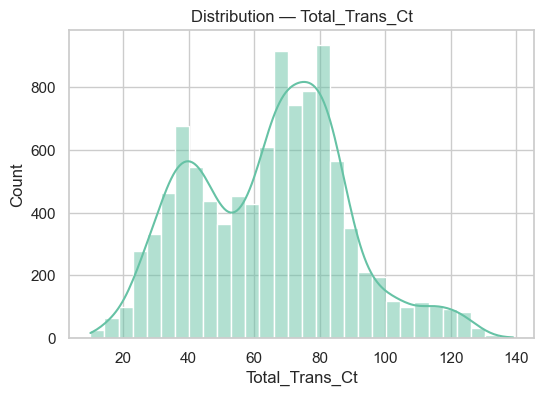

Saved: figuresAnalyse\02_box_Total_Trans_Ct.png


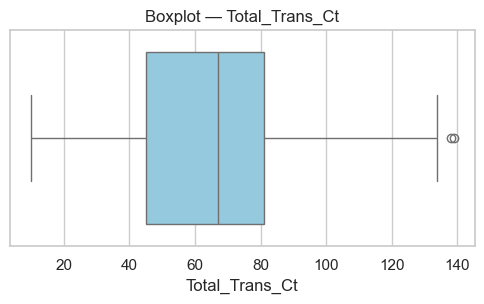

Saved: figuresAnalyse\02_hist_Total_Ct_Chng_Q4_Q1.png


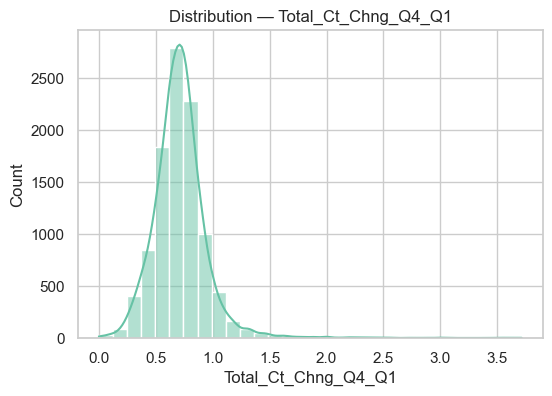

Saved: figuresAnalyse\02_box_Total_Ct_Chng_Q4_Q1.png


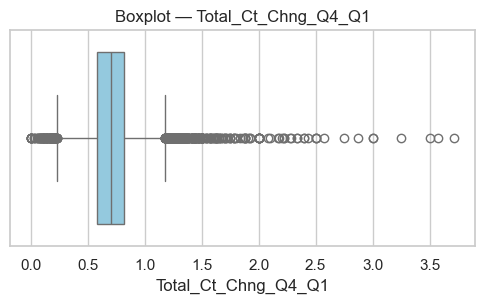

Saved: figuresAnalyse\02_hist_Avg_Utilization_Ratio.png


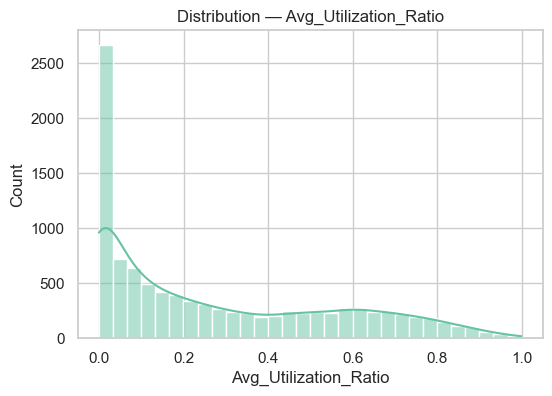

Saved: figuresAnalyse\02_box_Avg_Utilization_Ratio.png


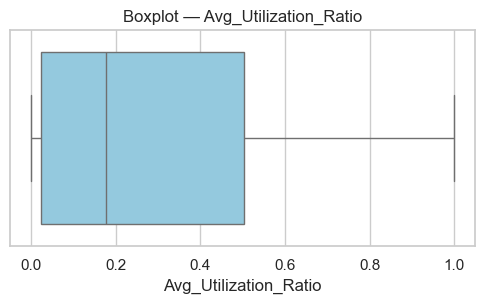

Colonnes catégorielles: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
Saved: figuresAnalyse\03_count_Gender.png


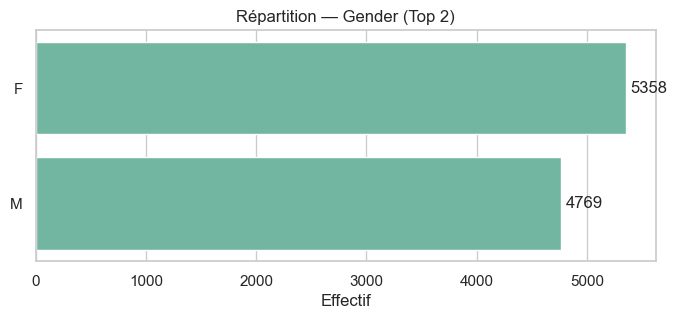

Saved: figuresAnalyse\03_count_Education_Level.png


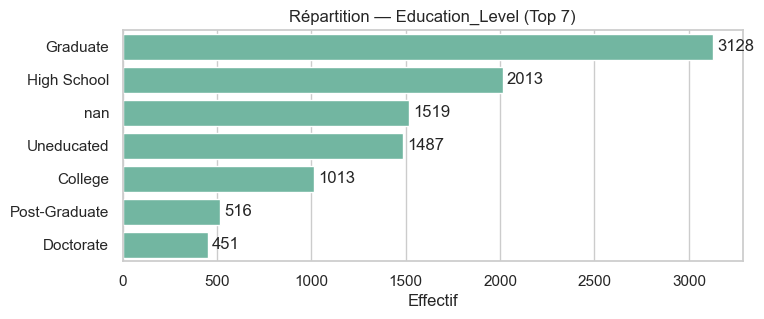

Saved: figuresAnalyse\03_count_Marital_Status.png


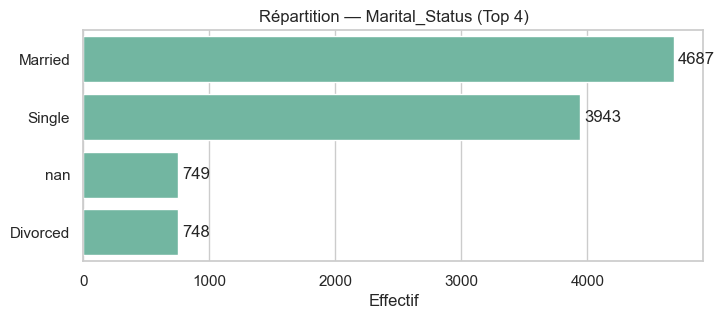

Saved: figuresAnalyse\03_count_Income_Category.png


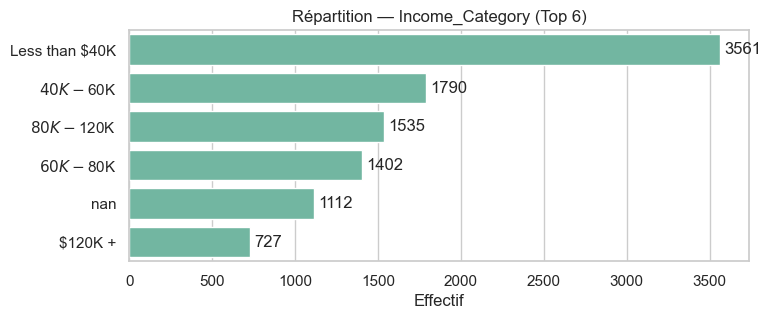

Saved: figuresAnalyse\03_count_Card_Category.png


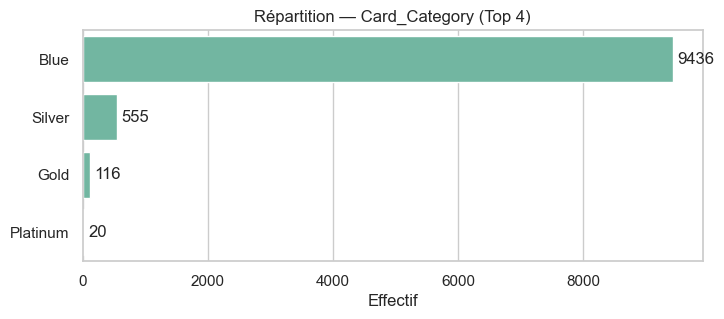

In [13]:
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in id_cols]
print("Colonnes numériques (extrait):", num_cols[:10])

for col in num_cols:
    plt.figure(figsize=(6,4))
    ax = sns.histplot(df_clean[col].dropna(), kde=True, bins=30)
    set_wrapped_title(ax, f"Distribution — {col}")
    save_fig(f"02_hist_{col}.png")
    plt.show()

    plt.figure(figsize=(6,2.8))
    ax = sns.boxplot(x=df_clean[col].dropna(), color="skyblue")
    set_wrapped_title(ax, f"Boxplot — {col}")
    save_fig(f"02_box_{col}.png")
    plt.show()

cat_cols = df_clean.select_dtypes(include=['object','category']).columns.tolist()
print("Colonnes catégorielles:", cat_cols)

for col in cat_cols:
    vc = df_clean[col].value_counts(dropna=False).sort_values(ascending=False).head(20)
    plt.figure(figsize=(8, max(3, 0.35*len(vc))))
    ax = sns.barplot(x=vc.values, y=[wrap_text(v, 18) for v in vc.index], orient='h')
    ax.set_xlabel("Effectif")
    set_wrapped_title(ax, f"Répartition — {col} (Top {len(vc)})")
    for p, val in zip(ax.patches, vc.values):
        ax.annotate(f"{val}", (p.get_width(), p.get_y()+p.get_height()/2),
                    ha='left', va='center', xytext=(3,0), textcoords='offset points')
    save_fig(f"03_count_{col}.png")
    plt.show()


## Analyse bivariée — corrélations et lien à la cible

Saved: figuresAnalyse\04_corr_matrix.png


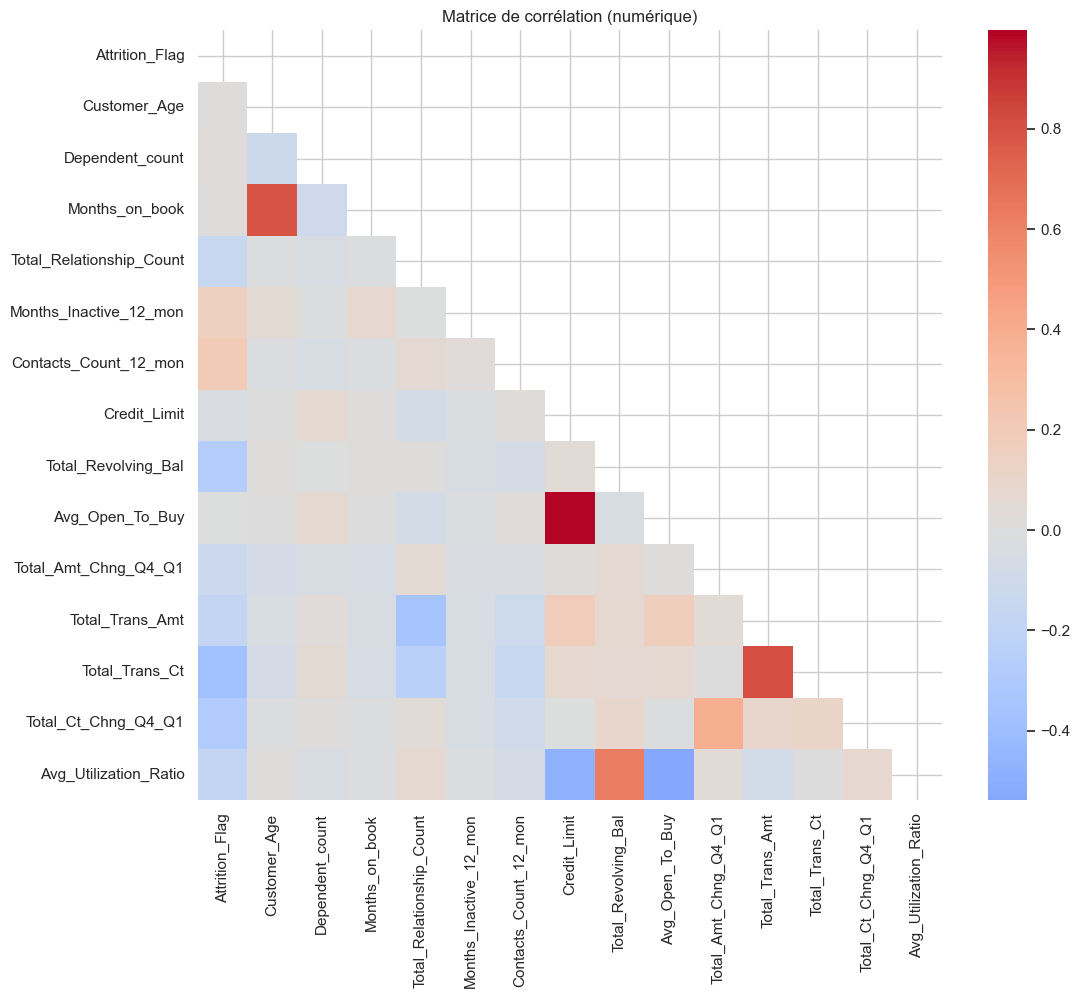

,feature,median_0,median_1,p_value
11,Total_Trans_Ct,71.000,43.000,0.000000e+00
12,Total_Ct_Chng_Q4_Q1,0.721,0.531,1.908241e-216
7,Total_Revolving_Bal,1364.000,0.000,1.915679e-129
13,Avg_Utilization_Ratio,0.211,0.000,2.869097e-129
10,Total_Trans_Amt,4100.000,2329.000,2.719009e-112
5,Contacts_Count_12_mon,2.000,3.000,1.110888e-80
4,Months_Inactive_12_mon,2.000,3.000,5.423116e-67
3,Total_Relationship_Count,4.000,3.000,2.905717e-51
9,Total_Amt_Chng_Q4_Q1,0.743,0.701,1.064474e-24
6,Credit_Limit,4643.500,4178.000,3.007841e-07


Saved: figuresAnalyse\05_violin_Customer_Age_by_target.png


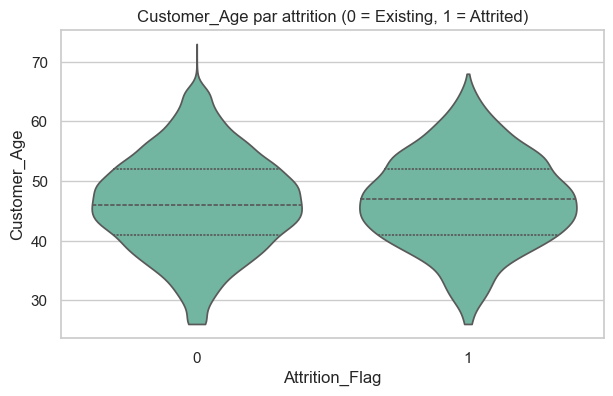

Saved: figuresAnalyse\05_violin_Dependent_count_by_target.png


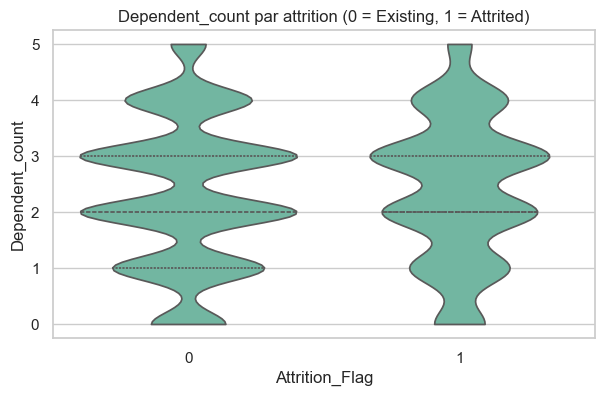

Saved: figuresAnalyse\05_violin_Months_on_book_by_target.png


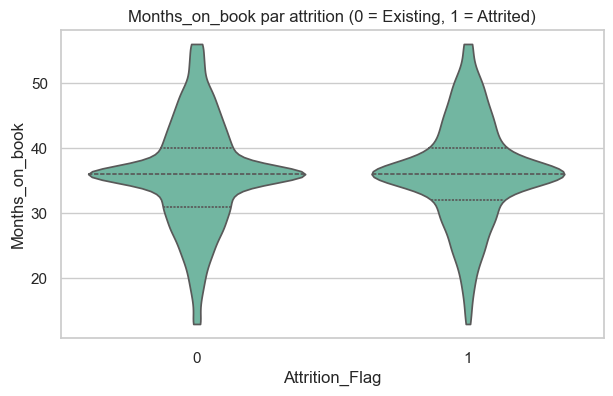

Saved: figuresAnalyse\05_violin_Total_Relationship_Count_by_target.png


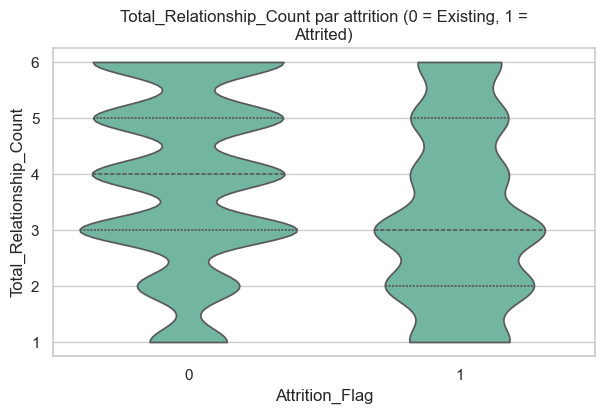

Saved: figuresAnalyse\05_violin_Months_Inactive_12_mon_by_target.png


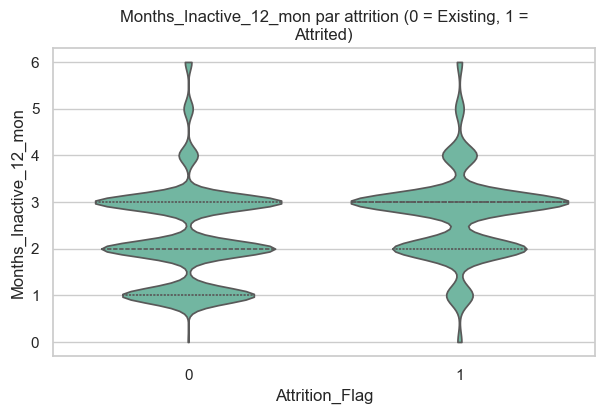

Saved: figuresAnalyse\05_violin_Contacts_Count_12_mon_by_target.png


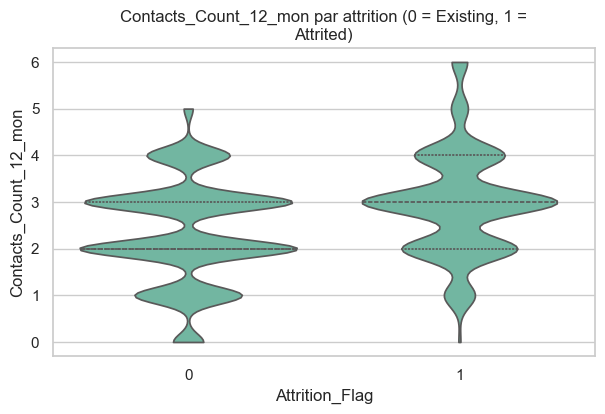

,feature,p_value,dof
0,Gender,0.000196,1
3,Income_Category,0.014814,4
1,Education_Level,0.038043,5
2,Marital_Status,0.071442,2
4,Card_Category,0.525238,3


Saved: figuresAnalyse\06_stacked_Gender_by_target.png


<Figure size 800x300 with 0 Axes>

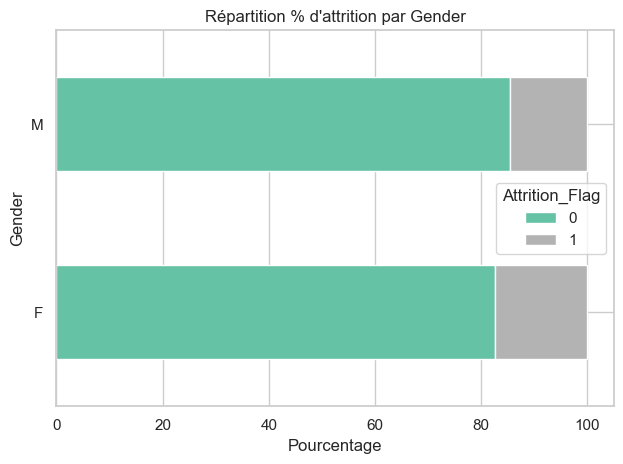

Saved: figuresAnalyse\06_stacked_Education_Level_by_target.png


<Figure size 800x300 with 0 Axes>

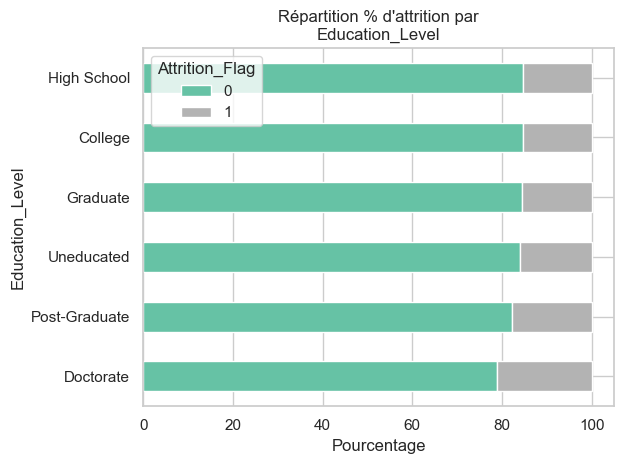

Saved: figuresAnalyse\06_stacked_Marital_Status_by_target.png


<Figure size 800x300 with 0 Axes>

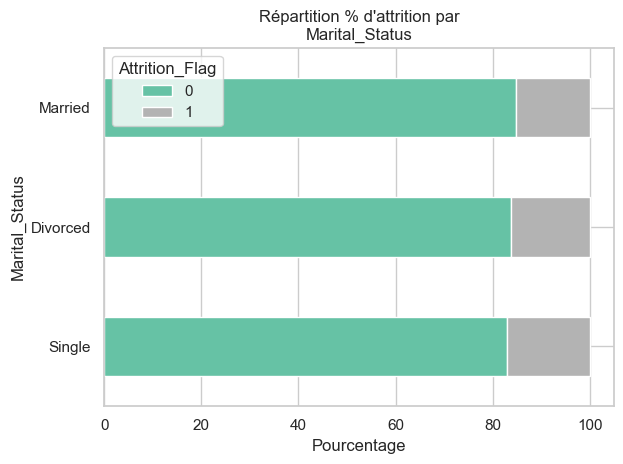

Saved: figuresAnalyse\06_stacked_Income_Category_by_target.png


<Figure size 800x300 with 0 Axes>

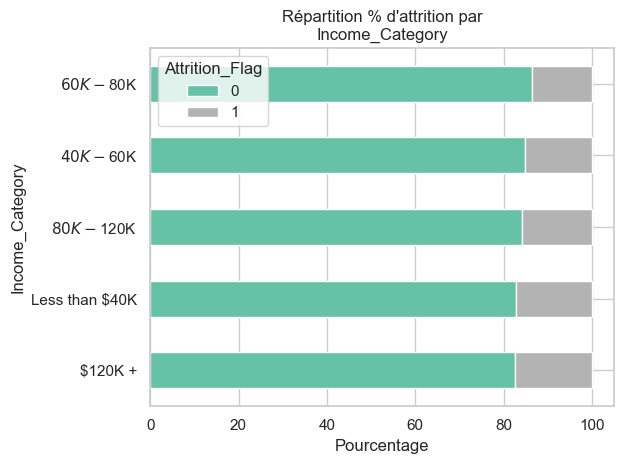

In [14]:
target = 'Attrition_Flag'
assert target in df_clean.columns, "La colonne 'Attrition_Flag' est absente."

# Corrélation num ↔ num
plt.figure(figsize=(12,10))
corr = df_clean[num_cols].corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, annot=False, cmap='coolwarm', mask=mask, center=0)
set_wrapped_title(ax, "Matrice de corrélation (numérique)")
save_fig("04_corr_matrix.png")
plt.show()

# Tests num ↔ cible (Mann–Whitney)
num_vs_target_stats = []
for col in num_cols:
    if col == target:
        continue
    sub = df_clean[[col, target]].dropna()
    g0 = sub[sub[target]==0][col]
    g1 = sub[sub[target]==1][col]
    if len(g0)>0 and len(g1)>0:
        stat, p = mannwhitneyu(g0, g1, alternative='two-sided')
        num_vs_target_stats.append((col, float(g0.median()), float(g1.median()), float(p)))
res_num = pd.DataFrame(num_vs_target_stats, columns=['feature','median_0','median_1','p_value']).sort_values('p_value')
display(res_num.head(10))

# Visuels: violons sur quelques features
for col in [c for c in num_cols if c != target][:6]:
    plt.figure(figsize=(7,4))
    ax = sns.violinplot(x=target, y=col, data=df_clean, inner='quart', cut=0)
    set_wrapped_title(ax, f"{col} par attrition (0 = Existing, 1 = Attrited)")
    save_fig(f"05_violin_{col}_by_target.png")
    plt.show()

# Tests cat ↔ cible (Chi²)
chi2_rows = []
for col in cat_cols:
    ct = pd.crosstab(df_clean[col], df_clean[target])
    if ct.shape[0] > 1 and ct.shape[1] > 1:
        chi2, p, dof, exp = chi2_contingency(ct)
        chi2_rows.append((col, float(p), int(dof)))
chi2_df = pd.DataFrame(chi2_rows, columns=['feature','p_value','dof']).sort_values('p_value')
display(chi2_df.head(10))

# Visuels cat ↔ cible (stacked %)
for col in cat_cols[:4]:
    ct = pd.crosstab(df_clean[col], df_clean[target], normalize='index') * 100
    if 0 in ct.columns and 1 in ct.columns:
        ct = ct[[0,1]]
    plt.figure(figsize=(8, max(3, 0.4*len(ct))))
    ct.sort_values(ct.columns[-1], ascending=False).plot(kind='barh', stacked=True, colormap='Set2')
    plt.xlabel("Pourcentage")
    plt.title(wrap_text(f"Répartition % d'attrition par {col}"))
    save_fig(f"06_stacked_{col}_by_target.png")
    plt.tight_layout()
    plt.show()


## Détection des valeurs aberrantes (IQR)

In [15]:
outliers_summary = {}
for col in num_cols:
    if col == target:
        continue
    Q1, Q3 = df_clean[col].quantile(0.25), df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers_summary[col] = int(((df_clean[col] < lower) | (df_clean[col] > upper)).sum())
outliers_df = pd.DataFrame.from_dict(outliers_summary, orient='index', columns=['outliers']).sort_values('outliers', ascending=False)
display(outliers_df.head(10))


,outliers
Credit_Limit,984
Avg_Open_To_Buy,963
Total_Trans_Amt,896
Contacts_Count_12_mon,629
Total_Amt_Chng_Q4_Q1,396
Total_Ct_Chng_Q4_Q1,394
Months_on_book,386
Months_Inactive_12_mon,331
Customer_Age,2
Total_Trans_Ct,2


## Feature engineering

In [16]:
df_fe = df_clean.copy()

if set(['Total_Trans_Amt','Total_Trans_Ct']).issubset(df_fe.columns):
    df_fe['Avg_Trans_Amt_per_Trans'] = df_fe['Total_Trans_Amt'] / df_fe['Total_Trans_Ct'].replace({0: np.nan})

if 'Customer_Age' in df_fe.columns:
    df_fe['Age_Group'] = pd.cut(df_fe['Customer_Age'], bins=[18,30,45,60,120], labels=['18-30','31-45','46-60','60+'], right=True)

if 'Avg_Utilization_Ratio' in df_fe.columns:
    df_fe['Util_Bin'] = pd.cut(df_fe['Avg_Utilization_Ratio'], bins=[-0.01,0.1,0.3,0.6,1.0], labels=['<=10%','10-30%','30-60%','>60%'])

display(df_fe[['Avg_Trans_Amt_per_Trans','Age_Group','Util_Bin']].head())


,Avg_Trans_Amt_per_Trans,Age_Group,Util_Bin
0,27.238095,31-45,<=10%
1,39.121212,46-60,10-30%
2,94.350000,46-60,<=10%
3,58.550000,31-45,>60%
4,29.142857,31-45,<=10%


## Analyse multivariée (PCA, t-SNE, KMeans)

Saved: figuresAnalyse\07_pca_by_target.png


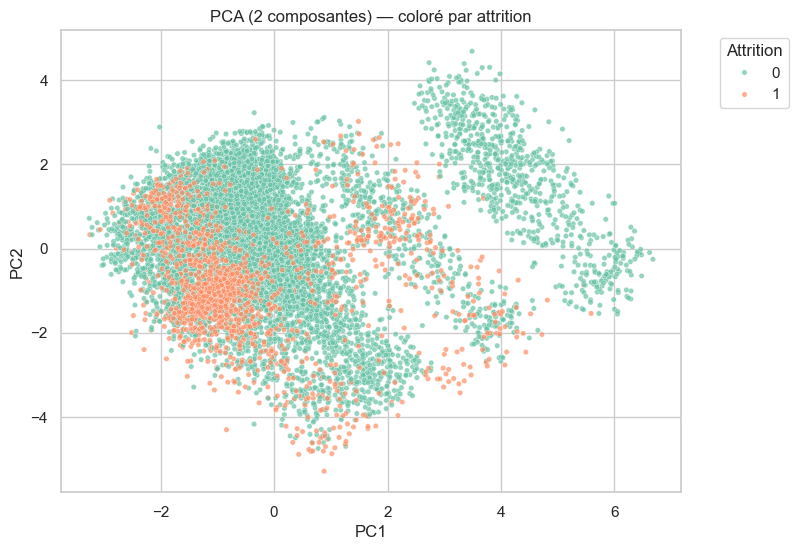

Explained variance ratio (PC1, PC2): [0.199 0.152]
Saved: figuresAnalyse\08_tsne_by_target.png


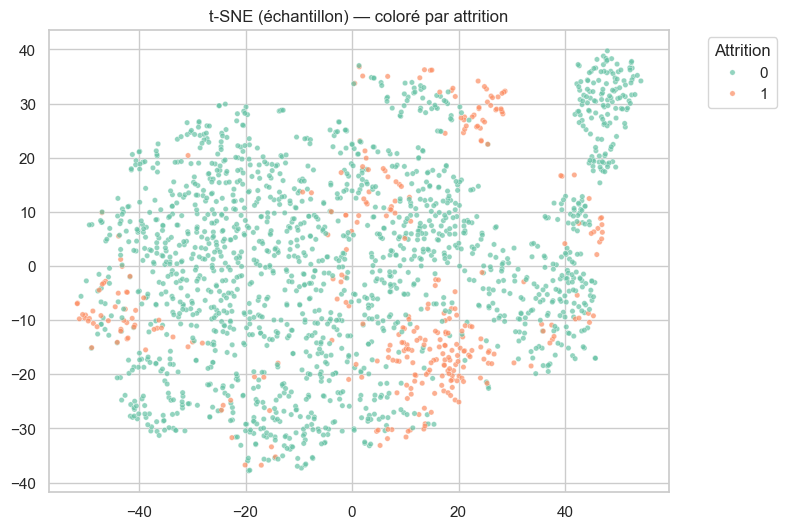

Saved: figuresAnalyse\09_kmeans_pca.png


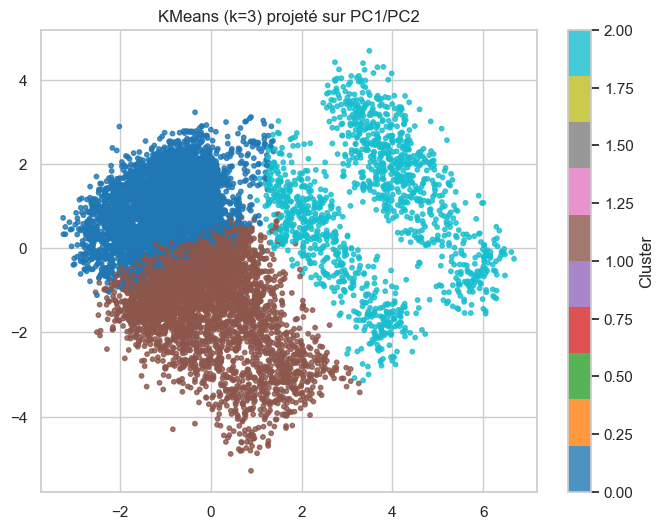

In [17]:
num_cols_fe = df_fe.select_dtypes(include=[np.number]).columns.tolist()
num_cols_fe = [c for c in num_cols_fe if c not in id_cols and c != target]

from sklearn.pipeline import make_pipeline
imp = SimpleImputer(strategy='median')
scaler = StandardScaler()
Xs = make_pipeline(imp, scaler).fit_transform(df_fe[num_cols_fe])

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(Xs)
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_fe[target], palette='Set2', s=15, alpha=0.7)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
set_wrapped_title(ax, "PCA (2 composantes) — coloré par attrition")
plt.legend(title='Attrition', bbox_to_anchor=(1.05,1), loc='upper left')
save_fig("07_pca_by_target.png")
plt.show()
print("Explained variance ratio (PC1, PC2):", np.round(pca.explained_variance_ratio_, 3))

# t-SNE (échantillon)
n_samples = min(2000, Xs.shape[0])
idx = np.random.choice(Xs.shape[0], n_samples, replace=False)
tsne = TSNE(n_components=2, random_state=42, init='pca', perplexity=30, learning_rate='auto')
X_tsne = tsne.fit_transform(Xs[idx])
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df_fe.iloc[idx][target], palette='Set2', s=15, alpha=0.7)
set_wrapped_title(ax, "t-SNE (échantillon) — coloré par attrition")
plt.legend(title='Attrition', bbox_to_anchor=(1.05,1), loc='upper left')
save_fig("08_tsne_by_target.png")
plt.show()

# KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(Xs)
plt.figure(figsize=(8,6))
ax = plt.gca()
sc = ax.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10', s=10, alpha=0.8)
plt.colorbar(sc, ax=ax, label='Cluster')
set_wrapped_title(ax, f"KMeans (k={k}) projeté sur PC1/PC2")
save_fig("09_kmeans_pca.png")
plt.show()


## Mini-modèle explicable (régression logistique)

Classification report (test):
              precision    recall  f1-score   support

           0      0.968     0.877     0.920      2125
           1      0.569     0.848     0.681       407

    accuracy                          0.872      2532
   macro avg      0.769     0.862     0.801      2532
weighted avg      0.904     0.872     0.882      2532

ROC-AUC: 0.932
Saved: figuresAnalyse\10_roc_logreg.png


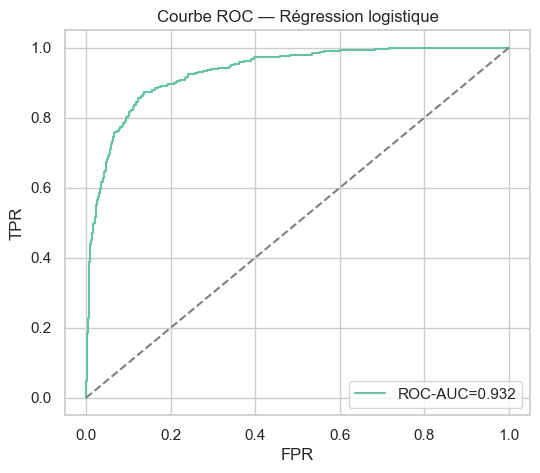

Saved: figuresAnalyse\11_confusion_logreg.png


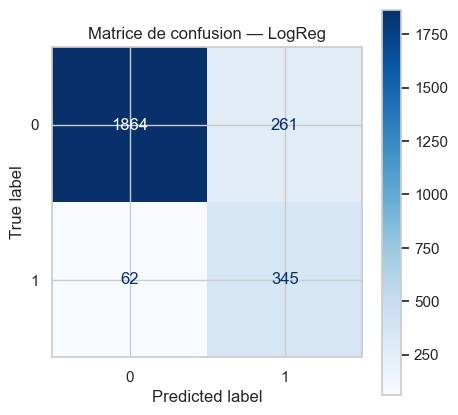

Avg_Trans_Amt_per_Trans        2.477367
Total_Trans_Amt               -1.901535
Total_Trans_Ct                -1.626397
Age_Group_18-30               -1.148385
Util_Bin_10-30%               -0.677820
Total_Ct_Chng_Q4_Q1           -0.661406
Gender_M                      -0.623602
Total_Relationship_Count      -0.621003
Contacts_Count_12_mon          0.602164
Card_Category_Blue            -0.551651
Months_Inactive_12_mon         0.526950
Card_Category_Gold             0.488913
Avg_Utilization_Ratio         -0.409671
Card_Category_Silver          -0.383260
Marital_Status_Married        -0.383176
Age_Group_46-60                0.364487
Util_Bin_30-60%               -0.362068
Total_Revolving_Bal           -0.292606
Util_Bin_<=10%                 0.278863
Income_Category_$60K - $80K   -0.277169
dtype: float64

Saved: figuresAnalyse\12_importances_logreg.png


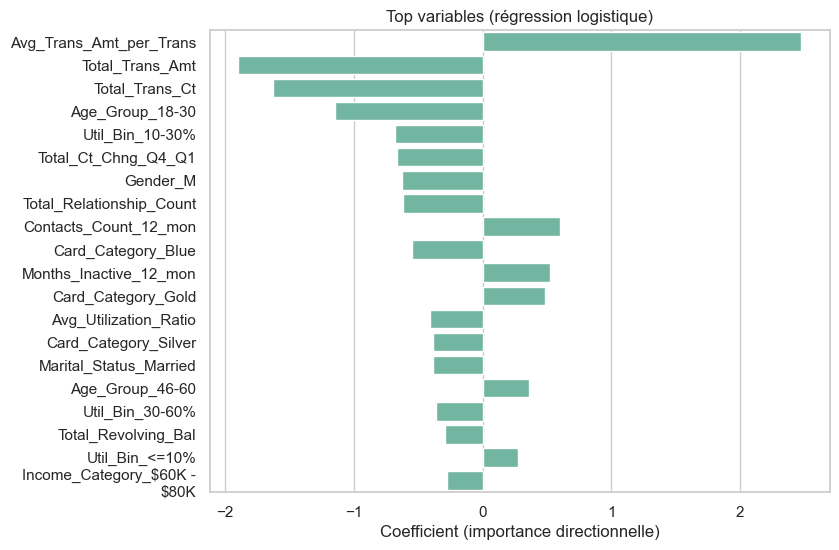

In [18]:
TARGET = 'Attrition_Flag'
y = df_fe[TARGET].astype(int)
X = df_fe.drop(columns=[TARGET] + id_cols) if len(id_cols)>0 else df_fe.drop(columns=[TARGET])

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Compatibilité OneHotEncoder (sparse_output depuis sklearn>=1.2)
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder='drop'
)

clf = LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear')
pipe = Pipeline(steps=[('preprocess', preprocess), ('clf', clf)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

print("Classification report (test):")
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Courbe ROC — Régression logistique")
plt.legend(loc='lower right')
save_fig("10_roc_logreg.png")
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap='Blues', ax=ax)
ax.set_title("Matrice de confusion — LogReg")
save_fig("11_confusion_logreg.png")
plt.show()

# Importance des features (coefficients)
coefs = pipe.named_steps['clf'].coef_[0]
feature_names = []
feature_names += num_features
cat_ohe = pipe.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
try:
    cat_out = list(cat_ohe.get_feature_names_out(cat_features)) if len(cat_features)>0 else []
except AttributeError:
    cat_out = list(cat_ohe.get_feature_names(cat_features)) if len(cat_features)>0 else []
feature_names += cat_out

imp = pd.Series(coefs, index=feature_names).sort_values(key=np.abs, ascending=False)
display(imp.head(20))

plt.figure(figsize=(8,6))
topn = 20
ax = sns.barplot(x=imp.head(topn).values, y=[wrap_text(v, 24) for v in imp.head(topn).index], orient='h')
ax.set_xlabel("Coefficient (importance directionnelle)")
set_wrapped_title(ax, "Top variables (régression logistique)")
save_fig("12_importances_logreg.png")
plt.show()


## Visualisation avancée: Pairplot (échantillon)

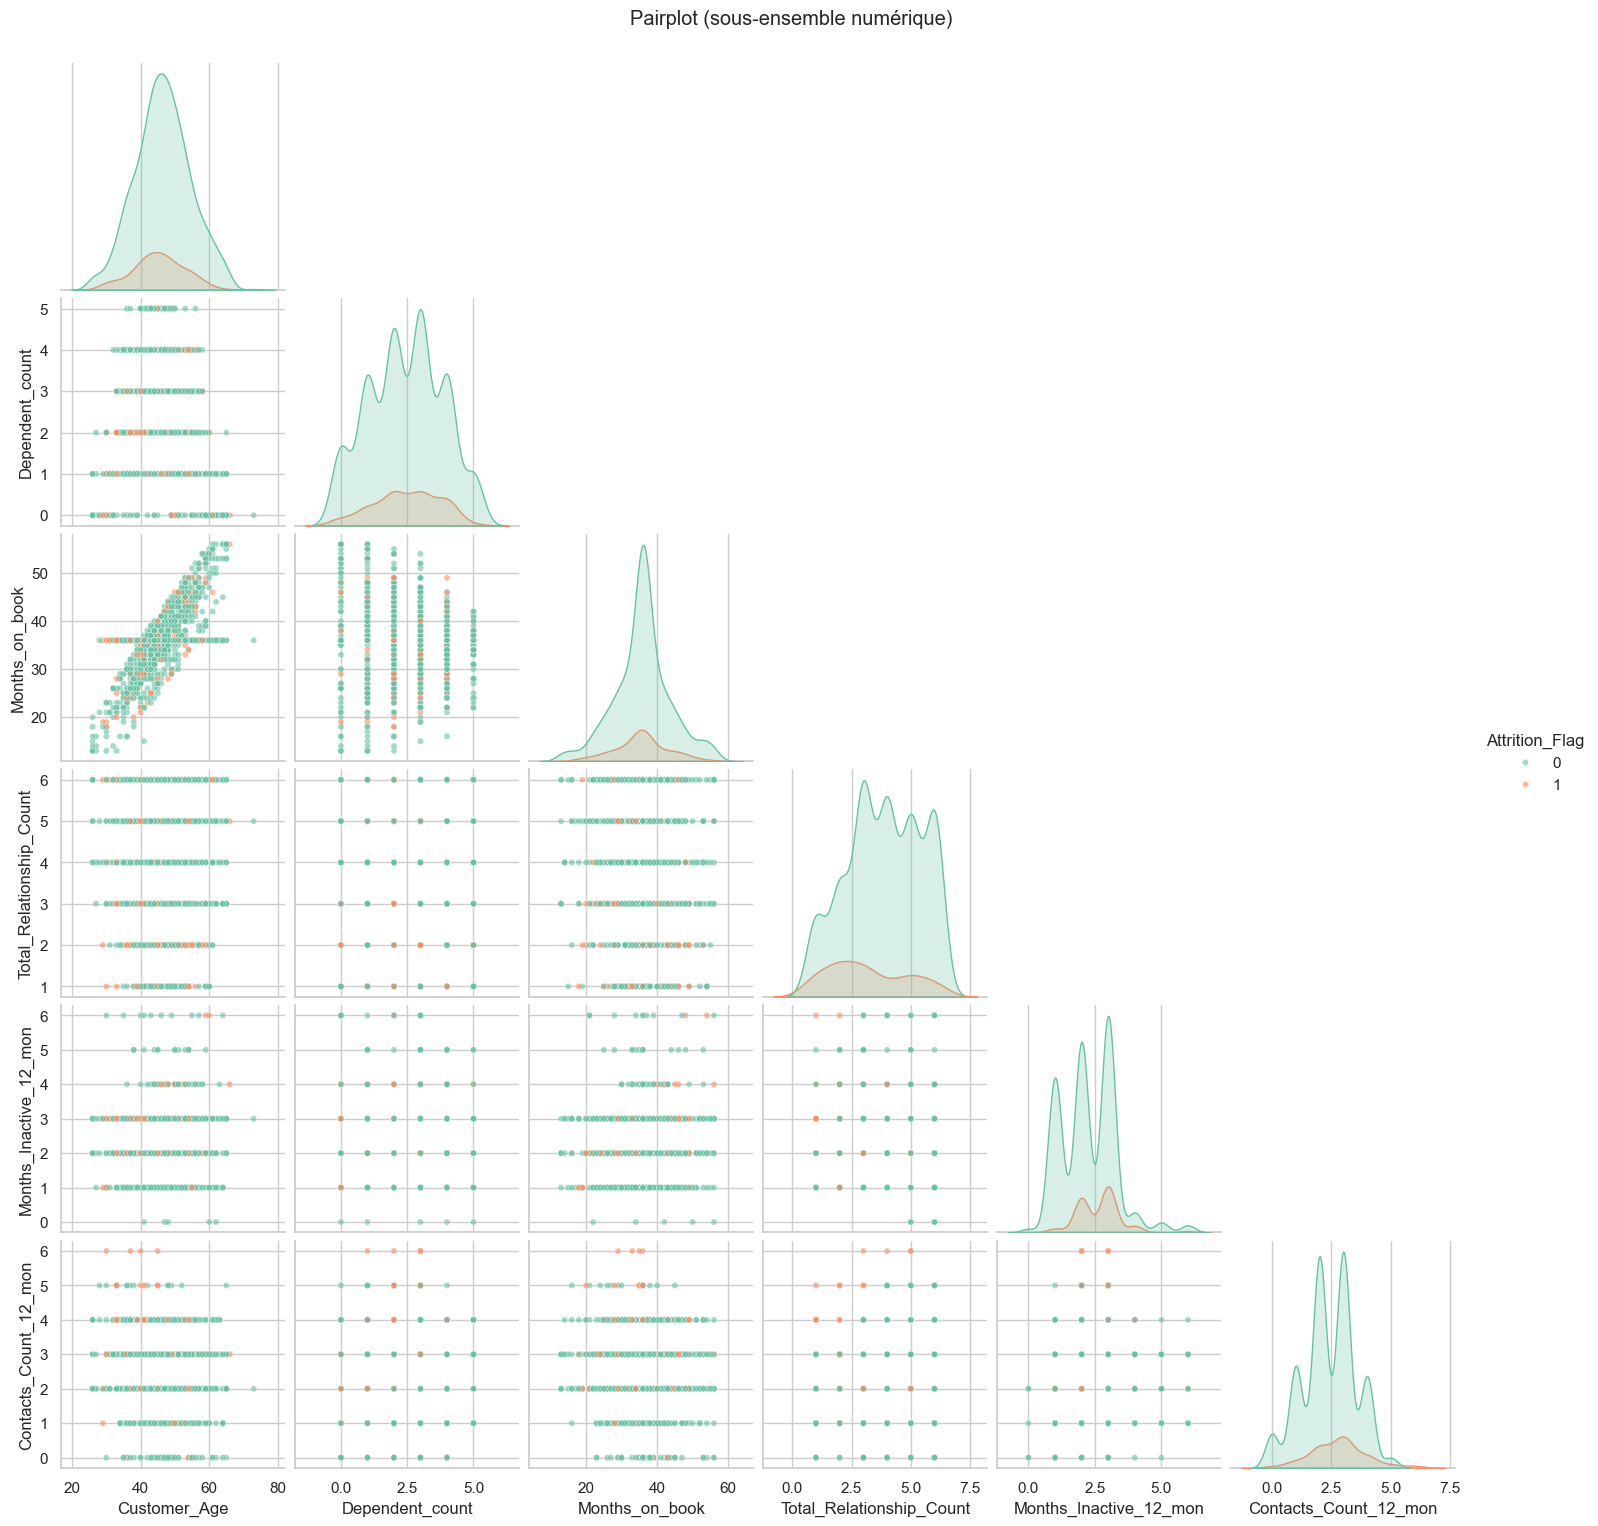

In [19]:
subset = df_fe.select_dtypes(include=[np.number]).columns.tolist()
subset = [c for c in subset if c not in id_cols and c != TARGET]
subset = subset[:6] if len(subset) > 6 else subset
if len(subset) >= 2:
    sample_df = df_fe[[*subset, TARGET]].dropna().sample(n=min(1000, len(df_fe)), random_state=42)
    g = sns.pairplot(sample_df, vars=subset, hue=TARGET, corner=True, diag_kind='kde', plot_kws={'alpha':0.6, 's':20})
    g.fig.suptitle(wrap_text("Pairplot (sous-ensemble numérique)"), y=1.02)
    g.savefig(os.path.join(FIG_DIR, "13_pairplot_subset.png"), dpi=300, bbox_inches='tight')
    plt.show()


# Conclusion

L’analyse exploratoire réalisée met en évidence les facteurs clés associés à l’attrition des clients, en s’appuyant sur un nettoyage rigoureux des données, des visualisations claires et des tests statistiques pertinents.  
La combinaison d’analyses descriptives, de méthodes multivariées et d’un modèle de régression logistique permet de dégager des leviers d’action concrets.

**Principaux enseignements :**
- Forte corrélation entre les indicateurs d’activité (`Total_Trans_Ct`, `Total_Trans_Amt`) et le churn, notamment lorsqu’ils sont en baisse.
- Impact significatif de l’inactivité récente (`Months_Inactive_12_mon`) et de la diminution du volume de transactions (`Total_Ct_Chng_Q4_Q1`).
- Influence de certaines caractéristiques socio‑démographiques et de produits (catégorie de carte, tranche de revenus).

**Recommandations stratégiques :**
- Mettre en place des campagnes de rétention ciblées sur les segments à risque, identifiés par le modèle prédictif.
- Surveiller régulièrement les métriques clés et actualiser le modèle pour prévenir la dérive des performances.
- Documenter et systématiser les règles de traitement des données afin de garantir la reproductibilité et la cohérence des analyses futures.

Cette approche fournit aux décideurs un outil robuste pour anticiper le départ des clients et mettre en œuvre des actions préventives fondées sur des données probantes.